In [1]:
import numpy as np
import pandas as pd
import os
import string
import requests
import re
import matplotlib.pyplot as plt

## Downloading the file

In [2]:
if not os.path.exists('data') :
    os.makedirs('data')
    if not os.path.exists('data', 'moby_dick.txt')  :
        print("Downloading moby dick...")
        r = requests.get('https://www.gutenberg.org/files/2701/2701-0.txt')
        with open(os.path.join('data', 'moby_dick.txt'), 'w', encoding='utf-8') as f:
            f.write(r.text)

## Tokenization

In [3]:
sequences = []
word_counts = {}

with open(os.path.join('data', 'moby_dick.txt'), encoding='utf-8') as f:
    for line in f:
        for word in line.split() :
            word_tokenized = []
            word = word.strip().lower()
            if word.isalpha() and len(word) > 1:
                for letter in word :
                    if letter in word_counts :
                        word_counts[letter] += 1
                    else :
                        word_counts[letter] = 1
                    word_tokenized.append(ord(letter) - 97)
                sequences.append(word_tokenized)

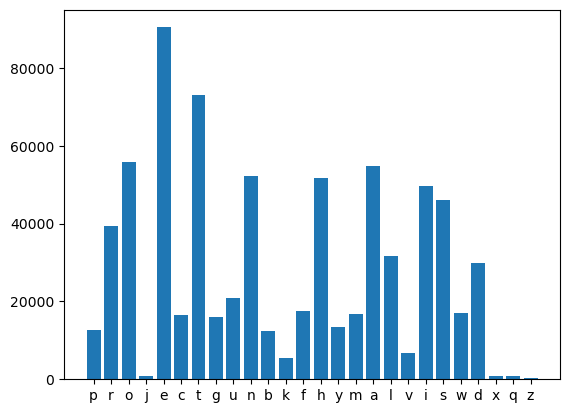

In [4]:
plt.bar(word_counts.keys(), word_counts.values());

In [5]:
M = len(word_counts)
M

26

In [6]:
pi = np.zeros((M), dtype = np.float64)
A = np.zeros((M, M), dtype = np.float64)

for sequence in sequences :
    pi[sequence[0]] += 1
    for j in range(1, len(sequence)) :
        A[sequence[j - 1], sequence[j]] += 1

display(pi, A[:5, :])

array([1.6798e+04, 8.7190e+03, 6.2180e+03, 4.0220e+03, 3.0300e+03,
       6.7050e+03, 2.6360e+03, 1.0693e+04, 1.0869e+04, 5.1600e+02,
       7.1300e+02, 4.3800e+03, 6.0100e+03, 3.7170e+03, 1.3084e+04,
       4.4180e+03, 3.9600e+02, 2.9740e+03, 1.3102e+04, 3.2218e+04,
       2.2930e+03, 1.1700e+03, 1.1706e+04, 2.0000e+00, 1.9580e+03,
       2.0000e+01])

array([[4.0000e+00, 1.3560e+03, 1.6810e+03, 2.2520e+03, 5.0000e+00,
        4.6600e+02, 9.9600e+02, 3.4200e+02, 2.2550e+03, 1.7000e+01,
        8.2400e+02, 5.8860e+03, 1.3480e+03, 1.2564e+04, 1.3000e+01,
        1.3150e+03, 1.0000e+00, 5.5770e+03, 5.6470e+03, 8.1890e+03,
        4.1500e+02, 1.3940e+03, 5.2600e+02, 2.2000e+01, 1.2570e+03,
        1.3100e+02],
       [5.5100e+02, 2.1200e+02, 0.0000e+00, 7.0000e+00, 3.3980e+03,
        0.0000e+00, 0.0000e+00, 4.0000e+00, 3.5800e+02, 5.2000e+01,
        0.0000e+00, 1.4600e+03, 1.1000e+01, 1.0000e+00, 1.4840e+03,
        0.0000e+00, 0.0000e+00, 6.1400e+02, 1.9900e+02, 9.2000e+01,
        2.1690e+03, 9.0000e+00, 0.0000e+00, 0.0000e+00, 1.3070e+03,
        0.0000e+00],
       [2.3160e+03, 0.0000e+00, 2.9800e+02, 0.0000e+00, 2.4510e+03,
        0.0000e+00, 0.0000e+00, 3.0760e+03, 9.0000e+02, 0.0000e+00,
        1.1360e+03, 5.7200e+02, 0.0000e+00, 0.0000e+00, 2.7410e+03,
        0.0000e+00, 1.0000e+01, 9.1500e+02, 2.1000e+01, 1.0410e+03,
      

## Add One Smoothing

In [7]:
smoothing_factor = 0.01
pi = (pi + smoothing_factor) / (pi.sum() + M * smoothing_factor)
A = (A + smoothing_factor)/ (A.sum(axis = 1, keepdims=True) + M * smoothing_factor)
# for i in range(A.shape[0]):
#     A[i] = (A[i] + 1) / (A[i].sum() + M)
display(pi.sum(), A.sum(axis = 1))

0.9999999999999999

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [8]:
log_pi = np.log(pi)
log_A = np.log(A)

In [9]:
def reverse_map(map_) :
    return {v: k for k, v in map_.items()}

def encode(map_, sequence) :  #map_ is a dictionary from original sequence space to encoded one,sequence is list of strings
    return [map_[i] for i in sequence]

def decode(map_, sequence) :  #map_ is a dictionary from original sequence space to encoded one, sequence is list of strings
    reverse = reverse_map(map_)
    return [reverse[i] for i in sequence]

def encode_message(message, cipher) :
    encoded_message = ''
    for i in message :
        i = i.lower()
        if i in cipher :
            encoded_message += cipher[i]
        elif i == ' ' or i == '\n':
            encoded_message += ' '
    return encoded_message

def decode_message(message, cipher) :
    decoded_message = ''
    rev_cipher = reverse_map(cipher)
    for i in message :
        if i in rev_cipher :
            decoded_message += rev_cipher[i]
        else :
            decoded_message += ' ' 
    return decoded_message

def model(decoded_message) :
    log_likelihood = 0
    
    for sequence in decoded_message.split() :
        if sequence.isalpha() :
            first_state = ord(sequence[0]) - 97
            log_likelihood += log_pi[first_state]
            for j in range(1, len(sequence) - 1) :
                second_state = ord(sequence[j]) - 97
                third_state = ord(sequence[j+1]) - 97
                log_likelihood += log_A[second_state, third_state]
    return log_likelihood

def get_random_cipher() :
    random_sequence = np.random.permutation(list(string.ascii_lowercase))
    cipher = dict(zip(list(string.ascii_lowercase), random_sequence))
    return cipher

def get_random_dna(n_sequences = None) :
    if n_sequences is None or n_sequences == 1 :
        return np.array(list(get_random_cipher().values()))
    random_sequences = []
    for _ in range(n_sequences) :
        random_sequences.append(np.array(list(get_random_cipher().values())))
    return np.array(random_sequences)

def covert_sequence_2_map(sequence) :
    return dict(zip(list(string.ascii_lowercase), sequence))

def f(sequence, encoded_message) :
    map_ = covert_sequence_2_map(sequence)
    decoded_msg = decode_message(encoded_message, map_)
    log_likelihood = model(decoded_msg)
    return log_likelihood

def evolve_offspring(dna_pool, n_children):
    # make n_children per offspring
    #print('Original : ', dna_pool.shape)
    offspring = []

    for dna in dna_pool:
        for _ in range(n_children):
            copy = dna.copy()
            j = np.random.randint(len(copy))
            k = np.random.randint(len(copy))

            # switch
            tmp = copy[j]
            copy[j] = copy[k]
            copy[k] = tmp
            offspring.append(copy)
    #print('Final : ', np.vstack((offspring, dna_pool)).shape)
    return np.vstack((offspring, dna_pool))

def translate_2_text(sequences) :
    translated_seq =  []
    for i in sequences :
        translated_word = ''
        for j in i :
            translated_word += list(word_index.keys())[j]
        translated_seq.append(translated_word)
    return translated_seq

In [10]:
cipher = get_random_cipher()
cipher

{'a': 'm',
 'b': 'n',
 'c': 'f',
 'd': 'p',
 'e': 'a',
 'f': 'z',
 'g': 'c',
 'h': 'd',
 'i': 'k',
 'j': 'h',
 'k': 'w',
 'l': 't',
 'm': 'i',
 'n': 'v',
 'o': 'x',
 'p': 'u',
 'q': 'l',
 'r': 's',
 's': 'e',
 't': 'r',
 'u': 'q',
 'v': 'b',
 'w': 'j',
 'x': 'g',
 'y': 'y',
 'z': 'o'}

In [11]:
original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

In [12]:
encoded_message = encode_message(original_message, cipher)
encoded_message

'k rdav txqvcap pxjv rda ersaar mvp zxqvp me k aguafrap rdmr rdasa jme m iaje kv m tmva jdkfd sqve pxjv ny xva jmtt xz rda cmspav k tavr rda xertase m dmvp kv sqnnkvc pxjv rdaks dxseae mvp safakbap kv agfdmvca rjxuavfa m ctmee xz dmtzmvpdmtz rjx zktte xz edmc rxnmffx mvp me iqfd kvzxsimrkxv me k fxqtp paeksa mnxqr ikee mptas rx emy vxrdkvc xz dmtz m pxoav xrdas uaxuta kv rda vakcdnxqsdxxp kv jdxi k jme vxr kv rda tamer kvrasaerap nqr jdxea nkxcsmudkae k jme fxiuattap rx tkerav rx '

In [19]:
print(f'Log likelihood of true encoding cypher : {f(list(cipher.values()), encoded_message)}')

Log likelihood of true encoding cypher : -776.4338408549215


In [52]:
MAX_ITER = 1000
log_likelihoods = []
DNA_pool = get_random_dna(10)
best_score = float('-inf')
best_dna = None
best_map = None
EPSILON = 0.2

for i in range(MAX_ITER) :    
    if i > 0 :
        DNA_pool = evolve_offspring(DNA_pool, 10)
        if np.random.randn() < EPSILON :
            DNA_pool = np.vstack((DNA_pool, get_random_dna(10)))
        scores = [f(DNA, encoded_message) for DNA in DNA_pool]
        #sort the DNA by score
        sorted_indices = np.argsort(scores)[::-1]
        #print(scores, sep='\n')
        sorted_DNA_pool = DNA_pool[sorted_indices]
        sorted_scores = np.array(scores)[sorted_indices]
        if best_score < sorted_scores[0] :
            best_score = sorted_scores[0]
            best_dna = sorted_DNA_pool[0]
            best_map = covert_sequence_2_map(best_dna)
         
        log_likelihoods.append(np.mean(sorted_scores))
        DNA_pool = sorted_DNA_pool[:5]
        
        if i % 100 == 0 :
            print(f'Iter {i}')
            print(f'Mean score : {np.mean(sorted_scores)} | Best Score : {best_score}')


Iter 100
Mean score : -1035.0539261409083 | Best Score : -762.6375095859437
Iter 200
Mean score : -1040.6818626991565 | Best Score : -760.9367486508767
Iter 300
Mean score : -875.1218921575562 | Best Score : -760.9367486508767
Iter 400
Mean score : -1032.0346330197217 | Best Score : -760.9367486508767
Iter 500
Mean score : -1032.104692726038 | Best Score : -760.9367486508767
Iter 600
Mean score : -1031.8615278266345 | Best Score : -760.9367486508767
Iter 700
Mean score : -869.9217203299394 | Best Score : -760.9367486508767
Iter 800
Mean score : -836.2906007066179 | Best Score : -760.9367486508767
Iter 900
Mean score : -1045.3247288464554 | Best Score : -760.9367486508767


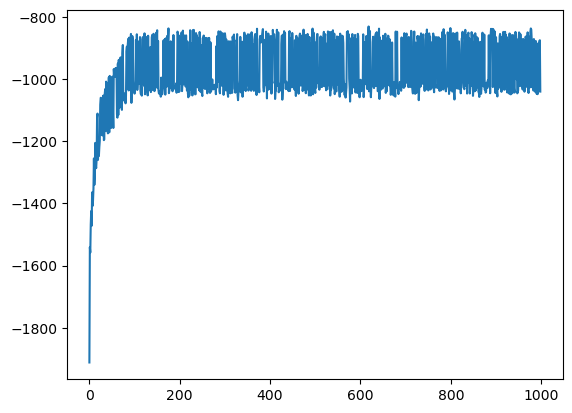

In [53]:
plt.plot(log_likelihoods)

In [54]:
original_message

'I then lounged down the street and found,\nas I expected, that there was a mews in a lane which runs down\nby one wall of the garden. I lent the ostlers a hand in rubbing\ndown their horses, and received in exchange twopence, a glass of\nhalf-and-half, two fills of shag tobacco, and as much information\nas I could desire about Miss Adler, to say nothing of half a dozen\nother people in the neighbourhood in whom I was not in the least\ninterested, but whose biographies I was compelled to listen to.\n'

In [55]:
encoded_message

'k rdav txqvcap pxjv rda ersaar mvp zxqvp me k aguafrap rdmr rdasa jme m iaje kv m tmva jdkfd sqve pxjv ny xva jmtt xz rda cmspav k tavr rda xertase m dmvp kv sqnnkvc pxjv rdaks dxseae mvp safakbap kv agfdmvca rjxuavfa m ctmee xz dmtzmvpdmtz rjx zktte xz edmc rxnmffx mvp me iqfd kvzxsimrkxv me k fxqtp paeksa mnxqr ikee mptas rx emy vxrdkvc xz dmtz m pxoav xrdas uaxuta kv rda vakcdnxqsdxxp kv jdxi k jme vxr kv rda tamer kvrasaerap nqr jdxea nkxcsmudkae k jme fxiuattap rx tkerav rx '

In [56]:
decode_message(encoded_message, best_map)

'i then lounged down the street and yound as i expected that there was a mews in a lane which runs down fb one wall oy the garden i lent the ostlers a hand in ruffing down their horses and received in exchange twopence a glass oy halyandhaly two yills oy shag tofacco and as much inyormation as i could desire afout miss adler to sab nothing oy haly a doken other people in the neighfourhood in whom i was not in the least interested fut whose fiographies i was compelled to listen to '

In [57]:
print(f'Decryption Accuracy : {(np.array(list(cipher.values())) == np.array(list(best_map.values()))).mean()}')

Decryption Accuracy : 0.8076923076923077


In [58]:
print('Wrongly decrypted : ')
for k, v in cipher.items() :
    if best_map[k] != v :
        print(f'True map : ({k} : {v}) | Wrong map : ({k} : {best_map[k]})')

Wrongly decrypted : 
True map : (b : n) | Wrong map : (b : y)
True map : (f : z) | Wrong map : (f : n)
True map : (k : w) | Wrong map : (k : o)
True map : (y : y) | Wrong map : (y : z)
True map : (z : o) | Wrong map : (z : w)
